In [17]:
import PbPMethods2 as pm2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
%matplotlib inline
base = getcwd() + '/'
folder = '/Users/muneebalam/Desktop/Imperial/BA report/'
figfolder = folder + 'Figures/'
startseason = 2013
endseason = 2015
testteams = {'WSH'}

In [18]:
"""Filter forwards"""
def get_forwards(seasons=None):
    fs = set()
    if seasons is None:
        seasons = {2015}
    for season in seasons:
        for team in pm2.get_teams(season):
            for line in pm2.read_team_corsi(team, season):
                for f in pm2.get_home_players(line, ['F']):
                    fs.add(f.lower())
    return fs

def get_number_dict(season, game):
    #to match Henrik Zetterberg to ZETTERBERG
    hdct = {}
    rdct = {}
    for line in pm2.read_game_corsi(season, game):
        for p in pm2.get_home_players(line):
            p = p.lower()
            first, last = p.split(' ', 1)
            hdct[p] = last
            if last in hdct:
                hdct[last].add(p)
            else:
                hdct[last] = {p}

        for p in pm2.get_road_players(line):
            p = p.lower()
            first, last = p.split(' ', 1)
            rdct[p] = last
            if last in rdct:
                rdct[last].add(p)
            else:
                rdct[last] = {p}
    return hdct, rdct

def match_name(p_org, num_name_dict):
    #matches #40 Zetterberg, 40 Zetterberg, or Zetterberg to Henrik Zetterberg
    if p_org == '#team':
        return 'team'
    elif p_org == 'n/a':
        return 'n/a'
    elif p_org in num_name_dict:
        return p_org
    #have to force-match when one team has two players who share a last name
    force_match = {'#22 sedin': 'daniel sedin', '#33 sedin': 'henrik sedin',
                  '#11 staal': 'jordan staal', '#12 staal': 'eric staal',
                  '#18 staal': 'marc staal',
                  '#25 hamilton': 'freddie hamilton', '#27 hamilton': 'dougie hamilton',
                  "#90 o'reilly": "ryan o'reilly", "#19 o'reilly": "cal o'reilly",
                  '#14 benn': 'jamie benn', '#24 benn': 'jordie benn',
                  '#10 schenn': 'brayden schenn', '#22 schenn': 'luke schenn',
                  '#86 miller': 'kevan miller', '#48 miller': 'colin miller',
                  '#28 moore': 'dominic moore', '#17 moore': 'john moore',
                  '#19 schultz': 'justin schultz', '#15 schultz': 'nick schultz',
                  '#54 jones': 'david jones', '#19 jones': 'blair jones',
                  '#26 st louis': 'martin st. louis'}
    matched = p_org
    if matched[0] == '#':
        matched = matched[matched.index(' ')+1:]
    else:
        try:
            num = int(matched[:2].strip()) #to see if the player has a number with no '#'
            matched = matched[matched.index(' ')+1:]
        except ValueError:
            pass
    try:
        matched = num_name_dict[matched.lower()]
    except Exception as e:
        if p_org in force_match:
            return force_match[p_org]
        raise e
    if len(matched) == 1:
        for p in matched:
            return p
    if len(matched) == 2:
        if p_org in force_match:
            p = force_match[p_org]
            return p
        else:
            print(p_org, matched)
            
r = open(folder + 'event counts for weighting.csv')
ADJUST_INFO = {0: {}, 1: {}} #0 = home, 1 = road
for line in r.read().strip().split('\n')[1:]:
    line2 = line.split(',')
    if line2[1] not in ADJUST_INFO[0]:
        ADJUST_INFO[0][line2[1]] = {}
        ADJUST_INFO[1][line2[1]] = {}
    ADJUST_INFO[0][line2[1]][int(line2[0])] = float(line2[-2])
    ADJUST_INFO[1][line2[1]][int(line2[0])] = float(line2[-1])
r.close()

def adjust(info, perspective_team):
    #Perspective team will be checked against acting team
    score1, score2 = pm2.get_event_score(info)
    scorediff = score1 - score2
    if scorediff < -3:
        scorediff = -3
    elif scorediff > 3:
        scorediff = 3
    coefi = 0
    if info[0] == '@':
        coefi = 1
    if pm2.get_acting_team(info) == perspective_team:
        return ADJUST_INFO[coefi][pm2.get_event_type(info)][scorediff]
    else:
        return ADJUST_INFO[1 - coefi][pm2.get_event_type(info)][-1 * scorediff]

Get GF60 and GA60 by game. I don't have GA data so need to generate this first.

In [19]:
gadatafile = base + 'shots against by game.csv'

def get_gadata(seasons=None, test=True):
    w = open(gadatafile, 'w')
    w.write('Season,Team,Name,Game,GAON,SvAON,MAON,BAON')

    if seasons is None:
        seasons = {2015}
    for season in seasons:
        if test:
            teams = testteams
        else:
            teams = pm2.get_teams(season)
        for team in teams:
            cur_game = None
            cur_player_number_dict = None
            cur_game_stats = {}
            homei = 0
            teamgame = 1
            for line in pm2.read_team_pbp(team, season, ['GOAL', 'SHOT', 'MISS', 'BLOCK']):
                g = pm2.get_game(line)
                if cur_game is None or not g == cur_game:
                    for p, stats in cur_game_stats.items():
                        w.write('\n{0:d},{1:s},{2:s},{3:d},{4:.3f},{5:.3f},{6:.3f},{7:.3f}'.format(
                            season, team, p, cur_game, stats[0], stats[1], stats[2], stats[3]))
                    teamgame += 1
                    cur_game = g
                    cur_player_number_dicts = get_number_dict(season, cur_game)
                    cur_game_stats = {}
                    homei = 0
                    if line[1][0] == '@':
                        homei = 1
                if not pm2.get_acting_team(line) == team:
                    adj = adjust(line, team)
                    ev = pm2.get_event_type(line)
                    if ev == 'GOAL':
                        i = 0
                    elif ev == 'SHOT':
                        i = 1
                    elif ev == 'MISS':
                        i = 2
                    elif ev == 'BLOCK':
                        i = 3
                    for f in pm2.get_home_players(line, ['F']):
                        f2 = f.lower().strip()
                        if f2 not in cur_game_stats:
                            cur_game_stats[f2] = [0, 0, 0, 0] #GA, SA, MA, BA
                        cur_game_stats[f2][i] += adj
            for p, stats in cur_game_stats.items():
                w.write('\n{0:d},{1:s},{2:s},{3:d},{4:.3f},{5:.3f},{6:.3f},{7:.3f}'.format(
                            season, team, p, cur_game, stats[0], stats[1], stats[2], stats[3]))
        print('Done with', season)
    w.close()
#get_gadata([2013, 2014, 2015], False)

In [20]:
toifile = base + 'toi by game.csv'
def read_toi():
    return pd.read_csv(toifile)

rtssfile = base + 'rtss by game.csv'
def read_rtss():
    return pd.read_csv(rtssfile)

boxcarfile = base + 'boxcars by game.csv'
def read_boxcars():
    return pd.read_csv(boxcarfile)

reboundfile = base + 'rebounds by game.csv'
def read_rebounds():
    return pd.read_csv(reboundfile)

def read_ga():
    return pd.read_csv(gadatafile)

def read_and_merge():
    boxcar = read_boxcars()
    rtss = read_rtss()
    toi = read_toi()
    rbd = read_rebounds()
    ga = read_ga()
    df = toi.merge(rtss, how='left', on=['Season', 'Team', 'Name', 'Game']).merge(
            boxcar, how='left', on=['Season', 'Team', 'Name', 'Game']).merge(
                rbd, how='left', on=['Season', 'Team', 'Name', 'Game']).merge(
                    ga, how='left', on=['Season', 'Team', 'Name', 'Game'])
    df['HRHelper'] = df['HR'].apply(lambda x: {'H': 0, 'R': 1}[x])
    df.fillna(value={'Hits': 0, 'Take': 0, 'Give': 0, 'PTake': 0, 'PDraw': 0, 'G': 0, 'Sv': 0, 'M': 0, 'B': 0,
                'A1': 0, 'A2': 0, 'GFON': 0, 'Rbd': 0}, inplace=True)
    df['RHits'] = df['Hits']*df['HRHelper']
    df['RGive'] = df['Give']*df['HRHelper']
    df['RTake'] = df['Take']*df['HRHelper']
    df['RTOI'] = df['TOI']*df['HRHelper']
    df['GameNum'] = df['GameNum'] - 1
    df['OddGame'] = df['GameNum'].apply(lambda x: x%2 == 1)
    return df
df = read_and_merge()
df.head()

,Season,Team,Name,Game,TOI,HR,GameNum,Hits,Take,Give,...,GAON,SvAON,MAON,BAON,HRHelper,RHits,RGive,RTake,RTOI,OddGame
0,2013,CBJ,ryan johansen,20018,537,H,1,0.929,0,0.864,...,0.000,2.062,1.031,2.066,0,0,0,0,0,True
1,2013,CBJ,blake comeau,20018,974,H,1,2.892,0,0.000,...,4.199,11.012,4.021,4.132,0,0,0,0,0,True
2,2013,CBJ,marian gaborik,20018,883,H,1,0.964,0,0.000,...,1.067,7.006,1.959,3.099,0,0,0,0,0,True
3,2013,CBJ,derek mackenzie,20018,561,H,1,0.000,0,0.000,...,2.065,6.068,1.031,0.000,0,0,0,0,0,True
4,2013,CBJ,mark letestu,20018,721,H,1,0.929,0,0.000,...,2.134,4.006,3.093,1.033,0,0,0,0,0,True


Group by team, name, and even (or odd) game. Calculate per-60 stats.

In [21]:
grouped = df.drop(['Season', 'Game', 'GameNum', 'Hits', 'Take', 'Give', 'PTake', 'PDraw', 'Rbd', 'iFen', 'RHits', 'RGive',
        'RTake', 'RTOI', 'HRHelper'], axis=1).groupby(['Team', 'Name', 'OddGame']).sum()
grouped['GFON60'] = grouped['GFON'] * 3600 / grouped['TOI']
grouped['GAON60'] = grouped['GAON'] * 3600 / grouped['TOI']
grouped['SvAON60'] = grouped['SvAON'] * 3600 / grouped['TOI']
grouped['MAON60'] = grouped['MAON'] * 3600 / grouped['TOI']
grouped['BAON60'] = grouped['BAON'] * 3600 / grouped['TOI']

grouped['iG60'] = grouped['G'] * 3600 / grouped['TOI']
grouped['iSv60'] = grouped['Sv'] * 3600 / grouped['TOI']
grouped['iM60'] = grouped['M'] * 3600 / grouped['TOI']
grouped['iB60'] = grouped['B'] * 3600 / grouped['TOI']
grouped['iA160'] = grouped['A1'] * 3600 / grouped['TOI']
grouped['iA260'] = grouped['A2'] * 3600 / grouped['TOI']
grouped.reset_index(inplace=True)
grouped.head()

,Team,Name,OddGame,TOI,G,Sv,M,B,A1,A2,...,GAON60,SvAON60,MAON60,BAON60,iG60,iSv60,iM60,iB60,iA160,iA260
0,ANA,andrew cogliano,False,102879,15.225,194.344,72.029,76.473,13.433,16.341,...,2.053784,29.439804,13.688566,16.052664,0.532762,6.800595,2.520479,2.675986,0.470055,0.571813
1,ANA,andrew cogliano,True,102570,18.906,173.465,75.172,76.688,21.328,8.577,...,2.722235,25.358748,12.757309,15.172612,0.663562,6.088271,2.638385,2.691594,0.748570,0.301035
2,ANA,brandon pirri,False,2943,1.943,5.769,2.839,8.159,0.000,0.000,...,2.603058,23.162080,12.375535,14.379205,2.376758,7.056881,3.472783,9.980428,0.000000,0.000000
3,ANA,brandon pirri,True,2921,0.995,5.186,0.866,3.001,0.000,0.000,...,2.639918,29.954810,13.749264,26.400411,1.226292,6.391510,1.067306,3.698596,0.000000,0.000000
4,ANA,carl hagelin,False,16206,2.945,41.275,19.789,13.857,1.882,2.877,...,1.863310,25.953054,10.344169,13.779563,0.654202,9.168826,4.395927,3.078193,0.418067,0.639097


Read skill prediction file into memory

In [22]:
skillsdf = pd.read_csv(folder + 'skill pred.csv')
cols = ['Player'] + [x for x in skillsdf.columns[-8:]]
skillsdf = skillsdf[cols]
skillsdf.head()

,Player,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_speed_mention%,pred_breakaways_mention%,pred_puck possession_mention%,pred_physical play_mention%,pred_take aways_mention%
0,nazem kadri,0.272538,0.409826,0.636073,0.947014,0.543642,0.275897,0.487518,0.177194
1,jay rosehill,-0.110226,-0.053820,0.858568,2.413251,1.281827,0.085267,1.354651,0.093489
2,jujhar khaira,-0.083545,-0.904890,-0.508143,-1.019200,-0.663539,-0.175603,1.058793,0.136844
3,darroll powe,NaN,NaN,-0.393702,-2.394930,-0.723520,-0.175603,0.684082,-0.035323
4,drew miller,0.216743,-0.093207,0.019078,-0.136015,-0.194874,0.092937,0.585311,0.239978


Write linemate data by game to file so I can weight TmG/60 etc accordingly.

In [23]:
linematefile = base + 'linemates by game.csv'
def get_linemates(seasons=None, test=True):
    w = open(linematefile, 'w')
    w.write('Season,Team,Name,Game,Linemate,TOI')

    if seasons is None:
        seasons = {2015}
    for season in seasons:
        if test:
            teams = testteams
        else:
            teams = pm2.get_teams(season)
        for team in teams:
            cur_game = None
            cur_game_toi = {}
            for line in pm2.read_team_toi(team, season):
                g = pm2.get_game(line)
                if cur_game is None or not g == cur_game:
                    for p, tdct in cur_game_toi.items():
                        for p2, t in tdct.items():
                            w.write('\n{0:d},{1:s},{2:s},{3:d},{4:s},{5:d}'.format(season, team,
                                                                         p.lower(), cur_game, p2.lower(), t))
                    cur_game = g
                    cur_game_toi = {}
                fs = pm2.get_home_players(line, ['F'])
                for f in fs:
                    if f not in cur_game_toi:
                        cur_game_toi[f] = {}
                    for f2 in fs:
                        if f2 not in cur_game_toi[f]:
                            cur_game_toi[f][f2] = 0
                        cur_game_toi[f][f2] += 1
            for p, tdct in cur_game_toi.items():
                for p2, t in tdct.items():
                    w.write('\n{0:d},{1:s},{2:s},{3:d},{4:s},{5:d}'.format(season, team,
                                                                 p.lower(), cur_game, p2.lower(), t))
            #print('Done with', team)
        print('Done with', season)
    w.close()
def read_linemates():
    return pd.read_csv(linematefile)

In [24]:
#get_linemates([2013, 2014, 2015], False)
lineys = read_linemates()
#lineys.head(10)

Join with other dataframe to get even and odd

In [25]:
lineys = lineys.merge(df[['Season', 'Team', 'Name', 'Game', 'OddGame']], how='right', on=['Season', 'Team', 'Name', 'Game'])
lineys.head()

,Season,Team,Name,Game,Linemate,TOI,OddGame
0,2013,EDM,jesse joensuu,20003,jesse joensuu,631,True
1,2013,EDM,jesse joensuu,20003,boyd gordon,553,True
2,2013,EDM,jesse joensuu,20003,taylor hall,33,True
3,2013,EDM,jesse joensuu,20003,jordan eberle,99,True
4,2013,EDM,jesse joensuu,20003,nail yakupov,540,True


Group by team/name/linemate/oddgame

In [26]:
lineys = lineys.drop(['Season', 'Game'], axis=1).groupby(['Team', 'Name', 'Linemate', 'OddGame']).sum()
lineys.reset_index(inplace=True)
lineys.head(10)

,Team,Name,Linemate,OddGame,TOI
0,ANA,andrew cogliano,andrew cogliano,False,102879
1,ANA,andrew cogliano,andrew cogliano,True,102570
2,ANA,andrew cogliano,brandon pirri,False,29
3,ANA,andrew cogliano,brandon pirri,True,22
4,ANA,andrew cogliano,carl hagelin,False,5744
5,ANA,andrew cogliano,carl hagelin,True,5047
6,ANA,andrew cogliano,chris stewart,False,1063
7,ANA,andrew cogliano,chris stewart,True,613
8,ANA,andrew cogliano,chris wagner,False,1071
9,ANA,andrew cogliano,chris wagner,True,924


Join on team and linemate and even/odd to get linemate stats

In [27]:
cols = ['Team', 'Name', 'OddGame', 'GFON60', 'GAON60', 'iG60', 'iSv60', 'iM60', 'iB60', 'iA160', 'iA260',
       'SvAON60', 'MAON60', 'BAON60']
lineys = lineys.merge(grouped[cols], how='inner', left_on=['Team', 'Linemate', 'OddGame'], right_on=['Team', 'Name', 'OddGame'])
lineys.drop(['Name_y'], axis=1, inplace=True)
lineys = lineys.merge(skillsdf, how='inner', left_on=['Linemate'], right_on=['Player'])
lineys.head()

,Team,Name_x,Linemate,OddGame,TOI,GFON60,GAON60,iG60,iSv60,iM60,...,BAON60,Player,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_speed_mention%,pred_breakaways_mention%,pred_puck possession_mention%,pred_physical play_mention%,pred_take aways_mention%
0,ANA,andrew cogliano,andrew cogliano,False,102879,1.882355,2.053784,0.532762,6.800595,2.520479,...,16.052664,andrew cogliano,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
1,ANA,brandon pirri,andrew cogliano,False,29,1.882355,2.053784,0.532762,6.800595,2.520479,...,16.052664,andrew cogliano,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
2,ANA,carl hagelin,andrew cogliano,False,5744,1.882355,2.053784,0.532762,6.800595,2.520479,...,16.052664,andrew cogliano,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
3,ANA,chris stewart,andrew cogliano,False,1063,1.882355,2.053784,0.532762,6.800595,2.520479,...,16.052664,andrew cogliano,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
4,ANA,chris wagner,andrew cogliano,False,1071,1.882355,2.053784,0.532762,6.800595,2.520479,...,16.052664,andrew cogliano,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915


Drop rows where Name_x == Linemate

In [28]:
lineys['Self'] = lineys['Name_x'] == lineys['Linemate']
lineys = lineys[lineys['Self'] == False]
lineys.drop(['Self', 'Player'], axis=1, inplace=True)
lineys.head()

,Team,Name_x,Linemate,OddGame,TOI,GFON60,GAON60,iG60,iSv60,iM60,...,MAON60,BAON60,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_speed_mention%,pred_breakaways_mention%,pred_puck possession_mention%,pred_physical play_mention%,pred_take aways_mention%
1,ANA,brandon pirri,andrew cogliano,False,29,1.882355,2.053784,0.532762,6.800595,2.520479,...,13.688566,16.052664,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
2,ANA,carl hagelin,andrew cogliano,False,5744,1.882355,2.053784,0.532762,6.800595,2.520479,...,13.688566,16.052664,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
3,ANA,chris stewart,andrew cogliano,False,1063,1.882355,2.053784,0.532762,6.800595,2.520479,...,13.688566,16.052664,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
4,ANA,chris wagner,andrew cogliano,False,1071,1.882355,2.053784,0.532762,6.800595,2.520479,...,13.688566,16.052664,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915
5,ANA,corey perry,andrew cogliano,False,4018,1.882355,2.053784,0.532762,6.800595,2.520479,...,13.688566,16.052664,0.220434,0.36523,0.177619,0.120886,0.023088,0.3883,0.539623,0.170915


Multiply each per-60 column by TOI, and each mention% column by TOI

In [29]:
for col in lineys.columns:
    if col[-2:] == '60' or col[-8:] == 'mention%':
        lineys[col + ' weight'] = lineys[col] * lineys['TOI']
lineys.head()

,Team,Name_x,Linemate,OddGame,TOI,GFON60,GAON60,iG60,iSv60,iM60,...,MAON60 weight,BAON60 weight,pred_passing_mention% weight,pred_shooting_mention% weight,pred_finesse_mention% weight,pred_speed_mention% weight,pred_breakaways_mention% weight,pred_puck possession_mention% weight,pred_physical play_mention% weight,pred_take aways_mention% weight
1,ANA,brandon pirri,andrew cogliano,False,29,1.882355,2.053784,0.532762,6.800595,2.520479,...,396.968419,465.527250,6.392594,10.591664,5.150956,3.505701,0.669561,11.260696,15.649056,4.956537
2,ANA,carl hagelin,andrew cogliano,False,5744,1.882355,2.053784,0.532762,6.800595,2.520479,...,78627.124136,92206.500919,1266.174536,2097.879840,1020.244563,694.370599,132.619320,2230.394444,3099.592269,981.736101
3,ANA,chris stewart,andrew cogliano,False,1063,1.882355,2.053784,0.532762,6.800595,2.520479,...,14550.945849,17063.981629,234.321645,388.239253,188.809187,128.502080,24.542886,412.762760,573.618834,181.682708
4,ANA,chris wagner,andrew cogliano,False,1071,1.882355,2.053784,0.532762,6.800595,2.520479,...,14660.454378,17192.402939,236.085120,391.161091,190.230140,129.469170,24.727593,415.869159,577.935815,183.050029
5,ANA,corey perry,andrew cogliano,False,4018,1.882355,2.053784,0.532762,6.800595,2.520479,...,55000.658910,64499.603184,885.704959,1467.493244,713.673860,485.720938,92.768877,1560.188871,2168.203645,686.736709


Sum over Name_x and OddGame, dropping rate columns

In [30]:
cols_needed = ['Team', 'Name_x', 'OddGame', 'TOI', 
               'GFON60 weight', 'GAON60 weight', 'iG60 weight', 'iSv60 weight', 'iM60 weight', 'iB60 weight', 
               'iA160 weight', 'iA260 weight', 'SvAON60 weight', 'MAON60 weight', 'BAON60 weight',
              'pred_passing_mention% weight', 'pred_shooting_mention% weight', 'pred_finesse_mention% weight', 
               'pred_speed_mention% weight', 'pred_breakaways_mention% weight', 'pred_puck possession_mention% weight', 
               'pred_physical play_mention% weight', 'pred_take aways_mention% weight']
summed = lineys[cols_needed].dropna().groupby(['Team', 'Name_x', 'OddGame']).sum()
summed.reset_index(inplace=True)
for col in summed.columns[4:-8].copy():
    summed['TmAvg ' + col[:col.index(' ')]] = summed[col] / summed['TOI']
    summed.drop(col, axis=1, inplace=True)
for col in summed.columns[4:12].copy():
    summed['TmAvg ' + col[col.index('_')+1:col.index('%')]] = summed[col] / summed['TOI']
    summed.drop(col, axis=1, inplace=True)
summed.head()

,Team,Name_x,OddGame,TOI,TmAvg GFON60,TmAvg GAON60,TmAvg iG60,TmAvg iSv60,TmAvg iM60,TmAvg iB60,...,TmAvg MAON60,TmAvg BAON60,TmAvg passing_mention,TmAvg shooting_mention,TmAvg finesse_mention,TmAvg speed_mention,TmAvg breakaways_mention,TmAvg puck possession_mention,TmAvg physical play_mention,TmAvg take aways_mention
0,ANA,andrew cogliano,False,204634,1.991005,1.998430,0.511840,6.603619,2.790615,2.667541,...,13.204177,16.293952,0.341810,0.248608,0.286096,0.170929,0.086654,0.351292,0.426646,0.197273
1,ANA,andrew cogliano,True,204313,2.357178,2.580694,0.590382,6.489120,3.071283,2.668622,...,13.263079,15.803889,0.342578,0.237677,0.284114,0.168108,0.083181,0.346391,0.427233,0.198850
2,ANA,brandon pirri,False,5886,2.641974,2.213286,0.793481,6.338615,2.467469,2.631805,...,11.569838,15.024971,0.368624,0.436095,0.267668,0.216347,0.122660,0.398589,0.497135,0.206652
3,ANA,brandon pirri,True,5850,2.466574,2.094755,0.724651,6.398507,3.313274,2.496875,...,12.764156,15.275630,0.354108,0.430102,0.306354,0.214277,0.154678,0.361763,0.463171,0.201683
4,ANA,carl hagelin,False,32326,1.960471,2.059056,0.535113,6.810978,2.703439,2.743397,...,12.693201,15.664910,0.341899,0.337320,0.306667,0.193094,0.128783,0.342271,0.437849,0.207791


Merge gfon60 and gaon60 from grouped, on team, name, and ~oddgame 

In [31]:
grouped['EvenGame'] = ~grouped['OddGame']
cols_needed = ['Team', 'Name', 'EvenGame', 'GFON60', 'GAON60']
summed = summed.merge(grouped[cols_needed], how='inner', left_on=['Team', 'Name_x', 'OddGame'], 
                      right_on=['Team', 'Name', 'EvenGame'])
summed.drop(['Name', 'EvenGame', 'TmAvg GFON60'], axis=1, inplace=True)
summed.rename(columns={'Name_x': 'Name', 'OddGame_x': 'OddGame', 'TOI_x': 'TOI', 
                       'GFON60': 'Out GFON60', 'GAON60': 'Out GAON60'}, inplace=True)
summed.head()

,Team,Name,OddGame,TOI,TmAvg GAON60,TmAvg iG60,TmAvg iSv60,TmAvg iM60,TmAvg iB60,TmAvg iA160,...,TmAvg passing_mention,TmAvg shooting_mention,TmAvg finesse_mention,TmAvg speed_mention,TmAvg breakaways_mention,TmAvg puck possession_mention,TmAvg physical play_mention,TmAvg take aways_mention,Out GFON60,Out GAON60
0,ANA,andrew cogliano,False,204634,1.998430,0.511840,6.603619,2.790615,2.667541,0.522981,...,0.341810,0.248608,0.286096,0.170929,0.086654,0.351292,0.426646,0.197273,2.378871,2.722235
1,ANA,andrew cogliano,True,204313,2.580694,0.590382,6.489120,3.071283,2.668622,0.568574,...,0.342578,0.237677,0.284114,0.168108,0.083181,0.346391,0.427233,0.198850,1.882355,2.053784
2,ANA,brandon pirri,False,5886,2.213286,0.793481,6.338615,2.467469,2.631805,0.742794,...,0.368624,0.436095,0.267668,0.216347,0.122660,0.398589,0.497135,0.206652,2.386032,2.639918
3,ANA,brandon pirri,True,5850,2.094755,0.724651,6.398507,3.313274,2.496875,0.609447,...,0.354108,0.430102,0.306354,0.214277,0.154678,0.361763,0.463171,0.201683,2.376758,2.603058
4,ANA,carl hagelin,False,32326,2.059056,0.535113,6.810978,2.703439,2.743397,0.558419,...,0.341899,0.337320,0.306667,0.193094,0.128783,0.342271,0.437849,0.207791,1.605789,3.063057


Merge individual stats again and write to file

In [32]:
cols_needed = ['Team', 'Name', 'OddGame', 'iG60', 'iSv60', 'iM60', 'iB60', 'iA160', 'iA260', 
               'GAON60', 'SvAON60', 'MAON60', 'BAON60']
summed = summed.merge(grouped[cols_needed], how='inner', on=['Team', 'Name', 'OddGame']).merge(
    skillsdf, how='inner', left_on=['Name'], right_on=['Player'])
summed.to_csv(folder + 'data for sawsh.csv')
summed.head()

,Team,Name,OddGame,TOI,TmAvg GAON60,TmAvg iG60,TmAvg iSv60,TmAvg iM60,TmAvg iB60,TmAvg iA160,...,BAON60,Player,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_speed_mention%,pred_breakaways_mention%,pred_puck possession_mention%,pred_physical play_mention%,pred_take aways_mention%
0,ANA,andrew cogliano,False,204634,1.998430,0.511840,6.603619,2.790615,2.667541,0.522981,...,16.052664,andrew cogliano,0.220434,0.365230,0.177619,0.120886,0.023088,0.388300,0.539623,0.170915
1,ANA,andrew cogliano,True,204313,2.580694,0.590382,6.489120,3.071283,2.668622,0.568574,...,15.172612,andrew cogliano,0.220434,0.365230,0.177619,0.120886,0.023088,0.388300,0.539623,0.170915
2,ANA,brandon pirri,False,5886,2.213286,0.793481,6.338615,2.467469,2.631805,0.742794,...,14.379205,brandon pirri,0.481900,0.491734,0.612657,0.500063,0.463427,0.383252,0.252472,0.207100
3,ANA,brandon pirri,True,5850,2.094755,0.724651,6.398507,3.313274,2.496875,0.609447,...,26.400411,brandon pirri,0.481900,0.491734,0.612657,0.500063,0.463427,0.383252,0.252472,0.207100
4,CHI,brandon pirri,False,17238,2.244812,0.970277,7.376416,2.628932,3.086306,0.719915,...,14.603727,brandon pirri,0.481900,0.491734,0.612657,0.500063,0.463427,0.383252,0.252472,0.207100


In [ ]:
summed.head()

Predict out stats

In [168]:
XlstF = ['iG60', 'iSv60', 'iM60', 'iB60', 'iA160', 'iA260',
        'TmAvg iG60', 'TmAvg iSv60', 'TmAvg iM60', 'TmAvg iB60', 'TmAvg iA160', 'TmAvg iA260']
XlstA = ['TmAvg GAON60', 'TmAvg SvAON60', 'TmAvg MAON60', 'TmAvg BAON60', 
         'GAON60', 'SvAON60', 'MAON60', 'BAON60']
XF = add_constant(summed[XlstF])
XA = add_constant(summed[XlstA])
yF = summed['Out GFON60']
yA = summed['Out GAON60']

In [170]:
ols = OLS(yF, XF)
mod = ols.fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:             Out GFON60   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     24.75
Date:                Wed, 31 Aug 2016   Prob (F-statistic):           1.21e-52
Time:                        18:25:14   Log-Likelihood:                -3167.5
No. Observations:                2178   AIC:                             6361.
Df Residuals:                    2165   BIC:                             6435.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.5684      0.190     -2.991      

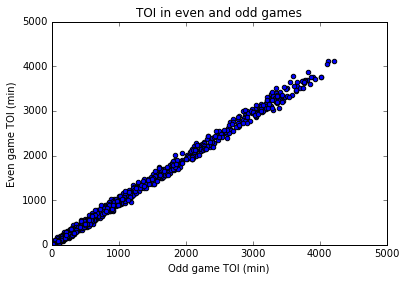

In [179]:
plt.scatter(summed[summed.OddGame].TOI/60, summed[~summed.OddGame].TOI/60)
plt.xlabel('Odd game TOI (min)')
plt.ylabel('Even game TOI (min)')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('TOI in even and odd games')
plt.savefig(figfolder + 'toi even odd.png')

Get all the indiv stats data from before and get rates and such

In [89]:
summed.columns

Index(['Team', 'Name_x', 'OddGame', 'TOI', 'pred_passing_mention%',
       'pred_shooting_mention%', 'pred_finesse_mention%',
       'pred_speed_mention%', 'pred_breakaways_mention%',
       'pred_puck possession_mention%', 'pred_physical play_mention%',
       'pred_take aways_mention%', 'TmAvg GFON60', 'TmAvg GAON60',
       'TmAvg iG60', 'TmAvg iSv60', 'TmAvg iM60', 'TmAvg iB60', 'TmAvg iA160',
       'TmAvg iA260', 'TmAvg SvAON60', 'TmAvg MAON60', 'TmAvg BAON60'],
      dtype='object')

Combine with linemate data so I have both indiv and tm stats

In [92]:
temp = summed[summed.columns[:-10]]
temp = temp[temp.Name_x == 'alex ovechkin']
temp.head()

,Team,Name_x,OddGame,TOI,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_speed_mention%,pred_breakaways_mention%,pred_puck possession_mention%,pred_physical play_mention%,pred_take aways_mention%,TmAvg GFON60
2169,WSH,alex ovechkin,False,225652,8.032898,2.208319,4.868652,2.487102,0.414232,7.165483,13.85898,5.805647,2.198409
2170,WSH,alex ovechkin,True,241435,8.032898,2.208319,4.868652,2.487102,0.414232,7.165483,13.85898,5.805647,2.397874


Run this model, even-->odd training and odd-->even test

Read in skill scores

Add variables for skill interaction into two models above

Compare results

Aggregate differences over teams and divide by three to get total value added by coaching

In [29]:
ovi = lineys[lineys['Name_x'] == 'alex ovechkin']
ovi.sum()

Team                                    WSHWSHWSHWSHWSHWSHWSHWSHWSHWSHWSHWSHWSHWSHWSHW...
Name_x                                  alex ovechkinalex ovechkinalex ovechkinalex ov...
Linemate                                daniel winnikdaniel winnikdustin pennerdustin ...
OddGame                                                                                28
TOI                                                                                467342
GFON60                                                                            101.635
GAON60                                                                            106.316
iG60                                                                               25.764
iSv60                                                                             319.999
iM60                                                                              131.034
iB60                                                                              147.086
iA160     

(array([  2.,   0.,   0.,   4.,   4.,   4.,  10.,  12.,  12.,   4.]),
 array([-0.75731149, -0.59732967, -0.43734785, -0.27736603, -0.11738421,
         0.04259761,  0.20257943,  0.36256125,  0.52254307,  0.68252489,
         0.84250671]),
 <a list of 10 Patch objects>)

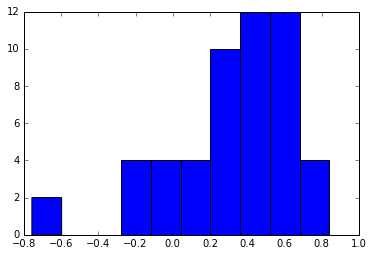

In [66]:
plt.hist(ovi['pred_passing_mention%'].dropna())

In [67]:
len(ovi)

57

In [75]:
temp = ovi[ovi.OddGame][['Linemate', 'TOI', 'pred_passing_mention%']].dropna()
temp['weight'] = temp['TOI'] * temp['pred_passing_mention%']
temp

,Linemate,TOI,pred_passing_mention%,weight
758,daniel winnik,122,0.209489,25.557661
1188,dustin penner,274,0.548188,150.203582
5334,martin erat,4413,0.361016,1593.165432
17447,curtis glencross,571,0.210419,120.148969
28094,justin williams,4870,0.688613,3353.545770
28246,mike richards,477,0.311982,148.815460
35362,mikhail grabovski,7811,0.523804,4091.435678
38803,chris brown,110,-0.071678,-7.884542
39486,chris conner,27,0.673136,18.174664
39895,zach sill,79,-0.757311,-59.827608


In [76]:
sum(temp.weight)

95781.224611254467

In [86]:
sum(temp.TOI)

241435

In [87]:
temp.sum()

Linemate                 daniel winnikdustin pennermartin eratcurtis gl...
TOI                                                                 241435
pred_passing_mention%                                               8.0329
weight                                                             95781.2
dtype: object

In [85]:
summed.columns

Index(['Team', 'Name_x', 'OddGame', 'TOI', 'TmAvg GFON60', 'TmAvg GAON60',
       'TmAvg iG60', 'TmAvg iSv60', 'TmAvg iM60', 'TmAvg iB60', 'TmAvg iA160',
       'TmAvg iA260', 'TmAvg SvAON60', 'TmAvg MAON60', 'TmAvg BAON60',
       'TmAvg passing_mention%', 'TmAvg shooting_mention%',
       'TmAvg finesse_mention%', 'TmAvg speed_mention%',
       'TmAvg breakaways_mention%', 'TmAvg puck possession_mention%',
       'TmAvg physical play_mention%', 'TmAvg take aways_mention%'],
      dtype='object')